## Citibike Usage Seasonal Dynamic

#### Introduction:
Citibike data shows that there is a seasonality with bike ridership for subscribers. It says that there is relatively low bike usage during winter time. 

It is presumed that many subscribers follow a pattern in trip duration, such as grocery shopping or commuting. However, it is not clear that whether there is a seasonal dynamic in such usage pattern. In this research, we look into citibike data generated by subscribers in summer months (July and August, 2015) and winter months (January and Febuary, 2015), in order to compare the seasonal difference in trip duration generated by subscribers.

### Hypothesis Development:
#### H0 = μ1 - μ2 = 0
We question if there is a significant difference between the mean of trip duration in summer months and winter months by subscribers. There is no difference in the average trip duration of subscribers in summer months as compared to the winter months.

#### H1= μ1 - μ2 != 0

We will use a significance level  $\alpha=0.05$

In [1]:
from __future__ import print_function
__author__='Shalmali'

%pylab inline
import pandas as pd
import os
import sys
import numpy as np
from scipy.stats import norm
from scipy import stats
from scipy.optimize import curve_fit, minimize
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
jul = pd.read_csv("201507-citibike-tripdata.csv")
aug = pd.read_csv("201508-citibike-tripdata.csv")
summer = pd.concat([jul, aug], axis = 0)

jan = pd.read_csv("201501-citibike-tripdata.csv")
feb = pd.read_csv("201502-citibike-tripdata.csv")
winter = pd.concat([jan, feb], axis = 0)

In [3]:
len(summer)

2264720

In [4]:
len(winter)

482482

In [5]:
# Subset a dataframe with subscribers only.
summer_sub = summer[summer['usertype'] == 'Subscriber']
winter_sub = winter[winter['usertype'] == 'Subscriber']

In [6]:
summer_sub[:5]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,732,7/1/2015 00:00:03,7/1/2015 00:12:16,489,10 Ave & W 28 St,40.750664,-74.001768,368,Carmine St & 6 Ave,40.730386,-74.002150,18669,Subscriber,1970.0,1
1,322,7/1/2015 00:00:06,7/1/2015 00:05:29,304,Broadway & Battery Pl,40.704633,-74.013617,3002,South End Ave & Liberty St,40.711512,-74.015756,14618,Subscriber,1984.0,1
2,790,7/1/2015 00:00:17,7/1/2015 00:13:28,447,8 Ave & W 52 St,40.763707,-73.985162,358,Christopher St & Greenwich St,40.732916,-74.007114,18801,Subscriber,1992.0,1
3,1228,7/1/2015 00:00:23,7/1/2015 00:20:51,490,8 Ave & W 33 St,40.751551,-73.993934,250,Lafayette St & Jersey St,40.724561,-73.995653,19137,Subscriber,1990.0,1
4,1383,7/1/2015 00:00:44,7/1/2015 00:23:48,327,Vesey Pl & River Terrace,40.715338,-74.016584,72,W 52 St & 11 Ave,40.767272,-73.993929,15808,Subscriber,1988.0,1


In [7]:
len(summer_sub)

1863362

In [8]:
summer_sub['tripduration'].describe()

count    1.863362e+06
mean     8.112439e+02
std      5.576341e+03
min      6.000000e+01
25%      3.820000e+02
50%      6.020000e+02
75%      9.600000e+02
max      3.611666e+06
Name: tripduration, dtype: float64

In [9]:
#We suspect there are outliers in our observations, therefore we need to clean
summer_dur = summer_sub['tripduration']
summer_dur_clean = summer_dur[(np.abs(stats.zscore(summer_dur)) < 3)]

winter_dur = winter_sub['tripduration']
winter_dur_clean = winter_dur[(np.abs(stats.zscore(winter_dur)) < 3)]

In [10]:
summer_dur_clean.describe()

count    1.861956e+06
mean     7.573256e+02
std      6.167404e+02
min      6.000000e+01
25%      3.820000e+02
50%      6.010000e+02
75%      9.590000e+02
max      1.753000e+04
Name: tripduration, dtype: float64

In [11]:
winter_dur_clean.describe()

count    472979.000000
mean        606.803974
std         403.792930
min          60.000000
25%         334.000000
50%         499.000000
75%         753.000000
max        3179.000000
Name: tripduration, dtype: float64

In [12]:
fig=pl.figure(figsize(15,15))
# Create trip duration bins, in this case we use 180 seconds (3 mins) as interval for the bins.
bins = np.arange(60, 4000, 180)

# Aggregates of trip duration:
ag_summer = summer_dur_clean.groupby(pd.cut(summer_dur_clean, bins)).agg([count_nonzero])
ag_winter = winter_dur_clean.groupby(pd.cut(winter_dur_clean, bins)).agg([count_nonzero])
ag_summer[:10]

,count_nonzero
tripduration,
"(60, 240]",162855
"(240, 420]",389737
"(420, 600]",376281
"(600, 780]",278427
"(780, 960]",190219
"(960, 1140]",132285
"(1140, 1320]",94049
"(1320, 1500]",68051
"(1500, 1680]",50284


In [13]:
ag_winter[:10]

,count_nonzero
tripduration,
"(60, 240]",53197
"(240, 420]",128993
"(420, 600]",111310
"(600, 780]",69319
"(780, 960]",40753
"(960, 1140]",23999
"(1140, 1320]",15323
"(1320, 1500]",10113
"(1500, 1680]",6676


In [14]:
ag_winter.columns = ['Winter Trip Duration']
ag_summer.columns = ['Summer Trip Duration']

In [15]:
# Then we would like to know the percentage of trips by trip duration in these two distributions:
per_sum = (ag_summer/len(summer_dur_clean))*100
per_win = (ag_winter/len(winter_dur_clean))*100

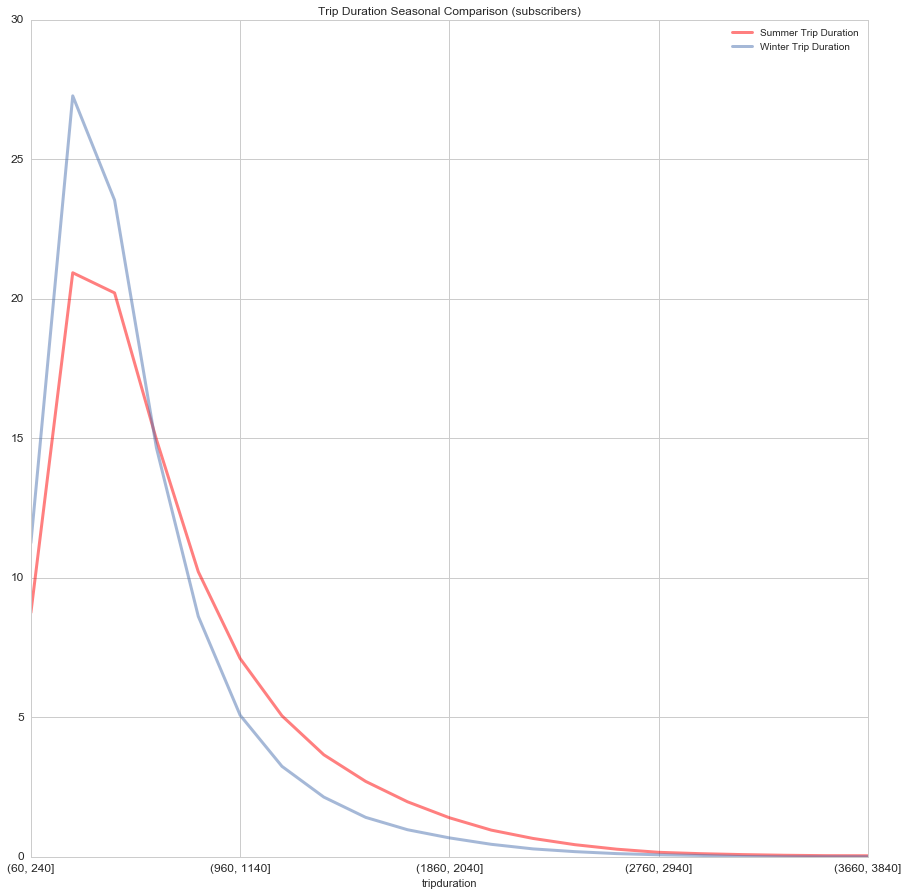

In [29]:
# Plot two trip duration distributions to compare the seasonal dynamic in trip duration.

fig = plt.figure(figsize(15,15))
ax = plt.subplot(111)
per_sum.plot(color = "r", linewidth=3, alpha = 0.5, ax=ax, title = "Trip Duration Seasonal Comparison (subscribers)", fontsize=12, label = "Summer Trip Duration")
ax = per_win.plot(linewidth=3, alpha = 0.5, ax=ax)